<a href="https://colab.research.google.com/github/rehann888/Forecasting-use-LTSM/blob/main/Pollution_Forecasting_use_LSTM_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This dataset reports weather and hourly pollution levels for five years at the US Embassy in Beijing, China, and the project's use of LTSM uses only 500 data. The model uses LTSM because LSTM is specifically designed to model sequential data and is able to handle time dependencies in data. In the case of pollution, pollution data is often time dependent, where current pollution levels are affected by previous pollution levels. The LSTM can take information from previous time steps and study complex time-dependent patterns and relationships in air pollution data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import torch
from torch.autograd import Variable
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_percentage_error as mape

1. **Exploratory Data Analysis (EDA)**

In [4]:
df = pd.read_csv("Pollution.csv")
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [5]:
df.index = pd.to_datetime(df['date'], format='%Y.%m.%d %H:%M:%S')
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,,
2010-01-02 00:00:00,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.3+ MB


In [7]:
df.index = df['date']

In [8]:
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,,
2010-01-02 00:00:00,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [9]:
df = df.drop(df.head(len(df)-500).index)

<Axes: xlabel='date'>

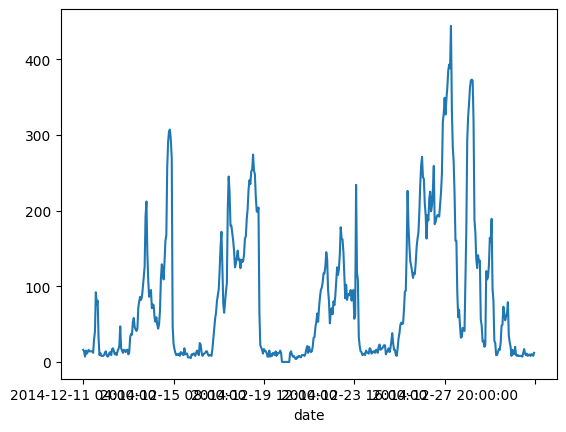

In [10]:
df['pollution'].plot()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 2014-12-11 04:00:00 to 2014-12-31 23:00:00
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       500 non-null    object 
 1   pollution  500 non-null    float64
 2   dew        500 non-null    int64  
 3   temp       500 non-null    float64
 4   press      500 non-null    float64
 5   wnd_dir    500 non-null    object 
 6   wnd_spd    500 non-null    float64
 7   snow       500 non-null    int64  
 8   rain       500 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 39.1+ KB


2. **Modelling Train and Test Data**

The input entered in this modeling is 5 (in hours). so that the train data has a time span of 5 hours. the train data used is 80% of the total data.

In [12]:
input=5
features=1

In [13]:
time_window=5

In [14]:
train = df.copy()

In [15]:
train.drop(['date', 'dew',	'temp',	'press',	'wnd_dir',	'wnd_spd',	'snow',	'rain'], axis=1, inplace=True)

In [16]:
train.tail()

,pollution
date,
2014-12-31 19:00:00,8.0
2014-12-31 20:00:00,10.0
2014-12-31 21:00:00,10.0
2014-12-31 22:00:00,8.0
2014-12-31 23:00:00,12.0


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 2014-12-11 04:00:00 to 2014-12-31 23:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  500 non-null    float64
dtypes: float64(1)
memory usage: 7.8+ KB


Normlization use *MinMax Scaller*

In [18]:
mmscaler = MinMaxScaler()
mmscaler.fit(train)
mmscaled_train = mmscaler.transform(train)

In [19]:
def windows(data, n_input):
    X_train=[]
    y_train=[]
    for i in range(n_input,len(data)):
        X_train.append(data[i-n_input:i])
        y_train.append(data[i])
    return np.array(X_train), np.array(y_train)

In [20]:
x, y = windows(mmscaled_train, time_window)

In [21]:
print(f'Array: \n {x[0].flatten()}')
print(f'Predict: \n {y[0]}')

Array: 
 [0.03603604 0.03153153 0.01576577 0.03378378 0.02477477]
Predict: 
 [0.02927928]


In [22]:
trains = int(len(train) * 0.8)
test = len(train) - trains

In [23]:
X = torch.Tensor(np.array(x))
Y = torch.Tensor(np.array(y))

X_train = torch.Tensor(np.array(x[:trains]))
y_train = torch.Tensor(np.array(y[:trains]))

X_test = torch.Tensor(np.array(x[trains:len(x)]))
y_test = torch.Tensor(np.array(y[trains:len(y)]))

In [24]:
print(trains)

400


In [25]:
print(test)

100


3. **Training Data use LTSM**

In [26]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )

        self.fc1 = nn.Linear(hidden_size,40)
        self.fc2 = nn.Linear(40,1)
        self.relu = nn.ReLU()

    def forward(self,x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        _, (h_out,_) = self.lstm(x, (h0,c0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc2(self.relu(self.fc1(h_out)))

        return out

The number of epochs of 1000 can help improve model performance and keep in mind that this must be balanced with performance monitoring and prevention of overfitting. so that the modeling can work properly and maximally. then the learning rate is 0.001 so that it tends to provide good training stability. In some cases, a learning rate that is too high can cause large fluctuations in weight changes, which can hinder model convergence and cause instability in training and also prevent overshot where learning rates that are too high can cause too large changes in weights which can cause the model to overshoot. optimum point and lead to unstable training. With a lower learning rate, the risk of overshot can be reduced.

In [27]:
INPUT = features
HIDDEN = 100
LAYERS = 1
EPOCHS = 1000
LEARNING_RATE = 0.001

In [28]:
model = LSTMNet(INPUT, HIDDEN, LAYERS)
print(model)

LSTMNet(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
)


In [29]:
X_train.shape,y_train.shape

(torch.Size([400, 5, 1]), torch.Size([400, 1]))

In [30]:
criteria = torch.nn.MSELoss()
optimize = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [31]:
early_stopping_patience = 150
early_stopping_counter = 0

valid_loss_min=np.inf

for epoch in range(EPOCHS):
    optimize.zero_grad()
    model.train()
    output = model(X_train)

    train_loss = criteria(output, y_train)

    train_loss.backward()
    optimize.step()


    with torch.no_grad():
        model.eval()
        output_val = model(X_test)
        valid_loss = criteria(output_val, y_test)

        if valid_loss <= valid_loss_min:
            print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
            valid_loss_min = valid_loss
            early_stopping_counter=0 #reset counter if validation loss decreases
        else:
            print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
            early_stopping_counter+=1

        if early_stopping_counter > early_stopping_patience:
            print('Early stopped at epoch :', epoch)
            break

        print(f'\t Train_Loss: {train_loss:.4f} Val_Loss: {valid_loss:.4f}  BEST VAL Loss: {valid_loss_min:.4f}\n')

Epoch 0: Validation loss decreased (inf --> 0.127106).  Saving model ...
	 Train_Loss: 0.0799 Val_Loss: 0.1271  BEST VAL Loss: 0.1271

Epoch 1: Validation loss decreased (0.127106 --> 0.119456).  Saving model ...
	 Train_Loss: 0.0738 Val_Loss: 0.1195  BEST VAL Loss: 0.1195

Epoch 2: Validation loss decreased (0.119456 --> 0.112134).  Saving model ...
	 Train_Loss: 0.0678 Val_Loss: 0.1121  BEST VAL Loss: 0.1121

Epoch 3: Validation loss decreased (0.112134 --> 0.105048).  Saving model ...
	 Train_Loss: 0.0622 Val_Loss: 0.1050  BEST VAL Loss: 0.1050

Epoch 4: Validation loss decreased (0.105048 --> 0.098017).  Saving model ...
	 Train_Loss: 0.0569 Val_Loss: 0.0980  BEST VAL Loss: 0.0980

Epoch 5: Validation loss decreased (0.098017 --> 0.091130).  Saving model ...
	 Train_Loss: 0.0519 Val_Loss: 0.0911  BEST VAL Loss: 0.0911

Epoch 6: Validation loss decreased (0.091130 --> 0.084680).  Saving model ...
	 Train_Loss: 0.0471 Val_Loss: 0.0847  BEST VAL Loss: 0.0847

Epoch 7: Validation loss 

**3. Prediction**

In [32]:
valid_predict = model(X_test)
y_pred_scaled = valid_predict.data.numpy()
y_pred = mmscaler.inverse_transform(y_pred_scaled)

In [33]:
df_pred=train.iloc[-95:]
df_pred['prediction']=y_pred

<ipython-input-33-a8b0f01ed06f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['prediction']=y_pred


<Axes: xlabel='date'>

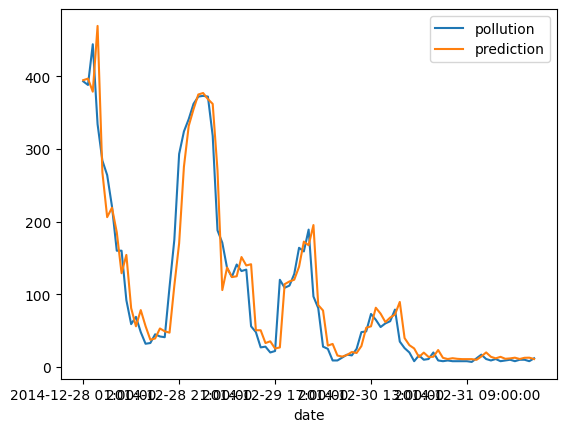

In [34]:
df_pred.plot()

**4.Evaluation**

In [35]:
rmse_lstm = mean_squared_error(df_pred["pollution"], df_pred["prediction"], squared=False)
print(f"RMSE OF LSTM MODEL : {rmse_lstm:.2f}")

RMSE OF LSTM MODEL : 34.02


In [36]:
mape_lstm = mape(df_pred["pollution"], df_pred["prediction"])
print(f"MAPE OF LSTM MODEL : {mape_lstm:.2f} %")

MAPE OF LSTM MODEL : 0.38 %


**5.Forecasting**

In [37]:
test_predictions = []

first_eval_batch = torch.Tensor(mmscaled_train[-input:])
current_batch=first_eval_batch.reshape((1,input,features))
for i in range(len(mmscaled_train[-input:])):
    current_pred = model(current_batch)
    test_predictions.append(current_pred)


    current_batch = torch.cat((current_batch[:,1:,:],current_pred.reshape(1,1,1)),1)

In [40]:
date=5
forecast_dates = (train.index + pd.DateOffset(hours=date))[-date:]
forecast_dates
train.index = pd.to_datetime(train.index)


In [41]:
value_forecast = mmscaler.inverse_transform(np.array([val.detach().numpy().flatten()[0] for val in test_predictions]).reshape(-1, 1))

In [42]:
forecast=pd.DataFrame({'date': forecast_dates})
forecast.set_index('date', inplace=True)
forecast['prediction'] = value_forecast
forecast.head(7)

,prediction
date,
2015-01-01 00:00:00,14.595340
2015-01-01 01:00:00,17.620678
2015-01-01 02:00:00,20.904421
2015-01-01 03:00:00,24.548981
2015-01-01 04:00:00,28.717901


In [43]:
df_all=df_pred.append(forecast)

<ipython-input-43-afc46786d185>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_pred.append(forecast)


<Axes: xlabel='date'>

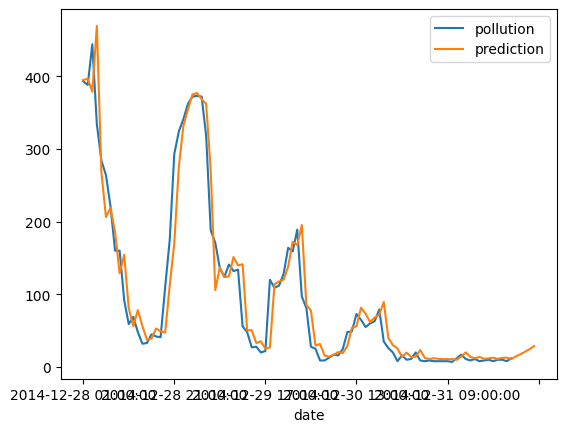

In [44]:
df_all.plot()